In [1]:
from tqdm import tqdm
import sys
import os

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import make_grid
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import random_split
from torchvision import datasets, transforms

from IPython import display
import time
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr


import ssl
ssl._create_default_https_context = ssl._create_unverified_context

from torch.utils.tensorboard import SummaryWriter
import time, datetime
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

c:\Users\Alessandro\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated and will be removed in a future release
  "class": algorithms.Blowfish,


In [2]:
# Define the transformation
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert image to a tensor.
    transforms.Resize((256, 256))  # Resize the image to 256x256 for each channel.
])

# Load the whole dataset
whole_dataset = datasets.EuroSAT(
    root="data",
    download=True,
    transform=transform
)

# Determine the lengths of the splits
train_len = int(len(whole_dataset) * 0.8)  # 80% for training
test_len = len(whole_dataset) - train_len  # 20% for testing

# Create the splits
training_data, test_data = torch.utils.data.random_split(whole_dataset, [train_len, test_len])

# Create the data loaders
train_dataloader = torch.utils.data.DataLoader(training_data, batch_size=32, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=32, shuffle=True)

Feature batch shape: torch.Size([32, 3, 256, 256])
Labels batch shape: torch.Size([32])


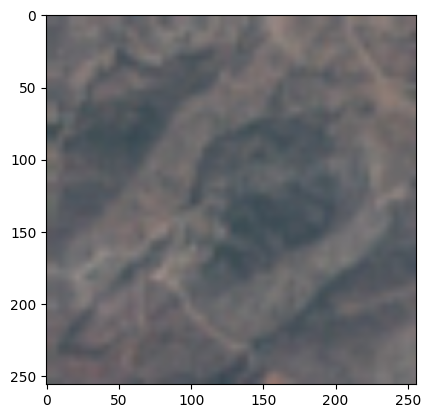

Label: 2


In [3]:
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].permute(1,2,0)
label = train_labels[0]
plt.imshow(img)
plt.show()
print(f"Label: {label}")

In [4]:
import math
import torch
import torch.nn.functional as F
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def train_one_epoch(train_dataloader, optimizer, aux_optimizer, net, lmbda):
    net.train()  # Set the model to training mode
    for i, (batch, _) in enumerate(train_dataloader):
        optimizer.zero_grad()
        aux_optimizer.zero_grad()
        batch = batch.to(device)

        outputs = net(batch)
        x_hat = outputs["x_hat"]
        y_likelihoods = outputs["likelihoods"]["y"]


        # Calculate the bitrate of the quantized latent
        N, C, H, W = batch.size()
        num_pixels = N * H * W *C

        bpp_loss = torch.log(y_likelihoods).sum() / (-math.log(2) * num_pixels)

        # Calculate the mean square error
        mse_loss = F.mse_loss(batch, x_hat)

        # Calculate PSNR
        max_i = 1.0  # Assuming the input is normalized to [0, 1]
        psnr = 10 * torch.log10(max_i ** 2 / mse_loss)

        # Calculate the final loss term
        loss = mse_loss + lmbda * bpp_loss
        loss.backward()
        optimizer.step()

        # Additional loss from the entropy bottleneck
        aux_loss = net.entropy_bottleneck.loss()
        aux_loss.backward()
        aux_optimizer.step()

        print(f"Batch {i}: Loss: {loss.item()}, PSNR: {psnr.item()}, BPP: {bpp_loss.item()}")
    return loss.item(), psnr.item()

def test_model(test_dataloader, net, device):
    net.eval()
    avg_psnr = 0.0
    avg_ssim = 0.0
    total_batches = len(test_dataloader)
    num_images_to_plot = 5
    fig, axs = plt.subplots(num_images_to_plot, 2, figsize=(10, 2 * num_images_to_plot))

    with torch.no_grad():
        for i, (batch, _) in enumerate(test_dataloader):
            batch = batch.to(device)
            outputs = net(batch)
            x_hat = outputs["x_hat"]
            y_likelihoods = outputs["likelihoods"]["y"]

            mse_loss = F.mse_loss(batch, x_hat)

            max_i = 1.0  # Normalize input to [0, 1]
            batch_psnr = 10 * torch.log10(max_i ** 2 / mse_loss)
            avg_psnr += batch_psnr.item()

            batch_ssim = ssim(batch.cpu().numpy(), x_hat.cpu().numpy(), channel_axis = 1, data_range=1)
            avg_ssim += batch_ssim

            # Plotting the original and reconstructed images
            if i < num_images_to_plot:
                axs[i, 0].imshow(batch[0].cpu().numpy().transpose(1, 2, 0))
                axs[i, 1].imshow(x_hat[0].cpu().numpy().transpose(1, 2, 0))
                axs[i, 0].set_title('Original')
                axs[i, 1].set_title('Reconstructed')

        avg_psnr /= total_batches
        avg_ssim /= total_batches

    plt.tight_layout()
    plt.show()
    print(f"Average PSNR: {avg_psnr}, Average SSIM: {avg_ssim}")

    return avg_psnr, avg_ssim, fig


# Main training loop
#lmbda = 0.1
#num_epochs = 1
#for epoch in range(num_epochs):
    #train_one_epoch(train_dataloader, optimizer, aux_optimizer, model.to(device), lmbda)
    #avg_psnr, avg_ssim = test_model(test_dataloader, model.to(device),device)
    #print(f"End of Epoch {epoch}: Test PSNR: {avg_psnr}, Test SSIM: {avg_ssim}")



In [5]:
def extract_latents(model, dataloader, device='cpu'):
    model.eval()  # Set the model to evaluation mode
    latents = []
    labels = []
    with torch.no_grad():  # Disable gradient computation
        for batch in dataloader:
            inputs, label = batch # Assuming the first element of batch is input data
            inputs = inputs.to(device)
            outputs = model(inputs)
            x_hat = outputs["x_hat"]
            latent = outputs["likelihoods"]["y"]
            # Flatten each latent in the batch before appending
            latents.append(latent.view(latent.size(0), -1).cpu().numpy())
            labels.append(label.cpu().numpy())
    return np.concatenate(latents, axis=0), np.concatenate(labels,axis = 0)  # This concatenates all the flattened latents into one array

# Assuming 'test_dataloader' is your DataLoader for the test set and 'vae_model' is your VAE model
#latents,labels = extract_latents(model.to(device), test_dataloader, device='cuda')


from sklearn.manifold import TSNE

def plot_tsne_with_labels(latents, labels, perplexity=30, n_components=2, n_iter=500):
    tsne = TSNE(n_components=n_components, perplexity=perplexity, n_iter=n_iter)
    T = tsne.fit_transform(latents)

    plt.figure(figsize=(10, 6))
    scatter = plt.scatter(T[:, 0], T[:, 1], c=labels, s=10, cmap='viridis', alpha=0.6)
    plt.colorbar(scatter, label='Class Labels')
    plt.title('t-SNE visualization of VAE Latents with Labels')
    plt.xlabel('t-SNE 1')
    plt.ylabel('t-SNE 2')
    plt.show()

# Call the plotting function
#plot_tsne_with_labels(latents, labels)


# Classification

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

class ConvClassifier(nn.Module):
    def __init__(self,in_size, num_classes=10):
        super(ConvClassifier, self).__init__()
        # Input size: [batch_size, 320, 4, 4]
        self.conv1 = nn.Conv2d(in_size, 128, kernel_size=3, padding=1)  # Output: [batch_size, 128, 4, 4]
        self.pool = nn.AdaptiveAvgPool2d((1, 1))  # Global average pooling to [batch_size, 128, 1, 1]
        self.fc1 = nn.Linear(128, num_classes)  # Fully connected layer

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = torch.flatten(x, 1)  # Flatten the dimensions [batch_size, 128]
        x = self.fc1(x)
        return x

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models

class ResNetClassifier(nn.Module):
    def __init__(self, num_classes=10):
        super(ResNetClassifier, self).__init__()
        # Load a pretrained ResNet model
        self.resnet = models.resnet18(pretrained=True)
        # Replace the final fully connected layer
        # Original ResNet18 has a 512-dimensional output before the fully connected layer
        self.resnet.fc = nn.Linear(512, num_classes)
        # Optionally, replace the original pooling with adaptive average pooling
        self.resnet.avgpool = nn.AdaptiveAvgPool2d((1, 1))

    def forward(self, x):
        # Forward pass through the modified ResNet
        x = self.resnet(x)
        return x


In [8]:
class MLPClassifier(nn.Module):
    def __init__(self, input_dim, num_classes=10):
        super(MLPClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = torch.flatten(x, 1)  # Flatten the input tensor
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


In [9]:
# Positional Encoding class
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe[:x.size(0), :]

# Transformer Classifier class
class TransformerClassifier(nn.Module):
    def __init__(self, in_size, num_classes=10, num_heads=8, num_layers=6, hidden_dim=512):
        super(TransformerClassifier, self).__init__()
        self.pos_encoder = PositionalEncoding(hidden_dim)
        encoder_layers = nn.TransformerEncoderLayer(hidden_dim, num_heads)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_layers)
        self.fc = nn.Linear(hidden_dim, num_classes)
        self.input_projection = nn.Linear(in_size, hidden_dim)

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten spatial dimensions
        x = self.input_projection(x)
        x = x.unsqueeze(1)  # Add a sequence dimension
        x = self.pos_encoder(x)
        x = self.transformer_encoder(x)
        x = x.mean(dim=1)  # Global average pooling
        x = self.fc(x)
        return x


In [10]:
class ResNetCustomInputClassifier(nn.Module):
    def __init__(self, input_dim, num_classes=10):
        super(ResNetCustomInputClassifier, self).__init__()
        # Load a pretrained ResNet model
        self.resnet = models.resnet18(pretrained=True)
        
        # Adjust the first convolutional layer to match the input channel size
        self.resnet.conv1 = nn.Conv2d(input_dim, 64, kernel_size=7, stride=2, padding=3, bias=False)
        
        # Modify the fully connected layer to adapt to the number of classes
        num_features = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(num_features, num_classes)

    def forward(self, x):
        x = self.resnet(x)
        return x



In [11]:
net = ConvClassifier(in_size = 192,num_classes=10).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)


In [12]:
def train(model, net, criterion, optimizer, train_loader, writer,alpha = 1, beta = 1,gamma = 1, epochs=50):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device).train()  # Encoder model in eval mode
    net = net.to(device).train()     # Classifier model in train mode

    for epoch in range(epochs):
        running_loss = 0.0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()  

            #with torch.no_grad(): USE FOR FROZEN MODELS
            cpr_output = model(inputs)
            latent = cpr_output["likelihoods"]["y"]
            
            x_hat = cpr_output["x_hat"]

            mse_loss = F.mse_loss(inputs, x_hat)
            
            # Calculate the bitrate of the quantized latent
            N, _, H, W = inputs.size()
            num_pixels = N * H * W 

            bpp_loss = torch.log(latent).sum() / (-math.log(2) * num_pixels)

            outputs = net(latent)
            loss = alpha * criterion(outputs, labels) + beta * bpp_loss + gamma * mse_loss
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        epoch_loss = running_loss / len(train_loader)
        print(f'Epoch {epoch + 1}, Loss: {epoch_loss}')
        writer.add_scalar('Loss/train', epoch_loss, epoch)



In [13]:
import torch
from sklearn.metrics import f1_score
from torch.utils.data import DataLoader
import math

def test(model, net, criterion, test_loader):
    model.eval()  # Set the model to evaluation mode
    net.eval()

    total_loss = 0.0
    total_correct = 0
    total_samples = 0
    all_labels = []
    all_preds = []

    with torch.no_grad():  # No gradients needed
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass through the model to get latent features and reconstruction
            cpr_output = model(inputs)
            x_hat = cpr_output["x_hat"]
            latent = cpr_output["likelihoods"]["y"]


            # Calculate the bitrate of the quantized latent
            N, _, H, W = inputs.size()
            num_pixels = N * H * W 

            bpp_loss = torch.log(latent).sum() / (-math.log(2) * num_pixels)

            # Forward pass through the classifier
            outputs = net(latent)

            # Calculate loss
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            # Calculate accuracy
            _, predicted = torch.max(outputs, 1)
            total_correct += (predicted == labels).sum().item()
            total_samples += labels.size(0)

            # Collect all labels and predictions for F1 score calculation
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

    # Calculate average loss, accuracy, and F1 score
    avg_loss = total_loss / len(test_loader)
    accuracy = total_correct / total_samples
    f1 = f1_score(all_labels, all_preds, average='weighted')  # weighted f1 score for multiclass classification

    print(f'Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}, F1 Score: {f1:.4f}, BPP: {bpp_loss:.4f}')


    return avg_loss, accuracy, f1, bpp_loss
#test(model, net, criterion, test_dataloader)


In [14]:
model = cheng2020_attn(quality = 2, metric = 'mse', pretrained = True, progress = True).to(device)
net = ConvClassifier(in_size = 192,num_classes=10).to(device)


NameError: name 'cheng2020_attn' is not defined

#Loop

In [14]:
from compressai.zoo import bmshj2018_hyperprior,bmshj2018_factorized,mbt2018_mean,mbt2018,cheng2020_anchor,cheng2020_attn
# Instantiate the model with MSE as the optimization metric and not pretrained

model_list = [bmshj2018_hyperprior]

model_list1 = [bmshj2018_hyperprior,bmshj2018_factorized]
model_list2 = [mbt2018_mean,mbt2018,cheng2020_anchor,cheng2020_attn]
model_list3 = [mbt2018]

## model = bmshj2018_hyperprior

In [ ]:
device = 'cuda:0'

for c_model in model_list1:

  if c_model in [bmshj2018_hyperprior, bmshj2018_factorized,mbt2018,mbt2018_mean]:
    start, step, end = 2, 3, 9  # Starting at 2, stepping by 3, up to but not including 9
    Bigger_size = True
  else:
    Bigger_size = False

    start, step, end = 4, 2, 7  # Starting at 2, stepping by 2, up to but not including 7



  print(c_model)

  for i in range(start, end, step):
    print(i)
    model = c_model(quality = i, metric = 'mse', pretrained = True, progress = True).to(device)
    writer = SummaryWriter(f'C:/Users/Alessandro/Desktop/Personal/Contribution 1/Scripts/Pretrained/Tensorboard/{datetime.datetime.now().strftime("%Y%m%d-%H%M%S")}'+f'_{c_model.__name__}'+f'_{i}'+'ResNet')

    if Bigger_size is True and i > 4:
       net = ResNetCustomInputClassifier(input_dim = 320,num_classes=10).to(device)
    elif Bigger_size is False and i < 4:
       net = ResNetCustomInputClassifier(input_dim = 128,num_classes=10).to(device)
    else:
       net = ResNetCustomInputClassifier(input_dim = 192,num_classes=10).to(device)
    

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(net.parameters(), lr=0.001)

    train(model.to(device), net.to(device), criterion, optimizer, train_dataloader,writer)
    avg_loss, accuracy, f1, bpp_loss = test(model, net, criterion, test_dataloader)

    writer.add_scalar(f'{c_model.__name__}_loss', avg_loss, i)
    writer.add_scalar(f'{c_model.__name__}_accuracy', accuracy, i)
    writer.add_scalar(f'{c_model.__name__}_f1', f1, i)
    writer.add_scalar(f'{c_model.__name__}_bpp', bpp_loss, i)


    ################################################# NEW CODE

    # Extract latents and labels
    latents, labels = extract_latents(model.to(device), test_dataloader, device=device)

    # Create a t-SNE plot and save to TensorBoard
    fig, ax = plt.subplots(figsize=(10, 6))
    tsne = TSNE(n_components=2, perplexity=30, n_iter=500)
    T = tsne.fit_transform(latents)
    scatter = ax.scatter(T[:, 0], T[:, 1], c=labels, s=10, cmap='viridis', alpha=0.6)
    plt.colorbar(scatter, label='Class Labels')
    plt.title(f't-SNE visualization of {c_model.__name__} Latents with Labels')
    plt.xlabel('t-SNE 1')
    plt.ylabel('t-SNE 2')
        
    # Log the t-SNE plot to TensorBoard
    writer.add_figure(f'{c_model.__name__}_t-SNE', fig, i)

    ################################################
    writer.flush()
    print(f'Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}, F1 Score: {f1:.4f}, BPP: {bpp_loss:.4f}')



In [ ]:
device = 'cuda'
beta = 1
for c_model in model_list:

  if c_model in [bmshj2018_hyperprior, bmshj2018_factorized,mbt2018,mbt2018_mean]:
    start, step, end = 2, 3, 9  # Starting at 2, stepping by 3, up to but not including 9
    Bigger_size = True
  else:
    Bigger_size = False

    start, step, end = 2, 2, 7  # Starting at 2, stepping by 2, up to but not including 7



  print(c_model)

  for i in range(start, end, step):
    print(i)
    model = c_model(quality = i, metric = 'mse', pretrained = True, progress = True).to(device)
    writer = SummaryWriter(f'C:/Users/Alessandro/Desktop/Personal/Contribution 1/Scripts/Pretrained/Tensorboard/{datetime.datetime.now().strftime("%Y%m%d-%H%M%S")}'+f'_{c_model.__name__}'+f'_{i}'+'_Transformer_FT'+f'Beta:_{beta}')

    if Bigger_size is True and i > 5:
      net = TransformerClassifier(in_size = 320 *16*16,num_classes=10).to(device)
    elif Bigger_size is False and i < 5:
      net = TransformerClassifier(in_size = 128*16*16,num_classes=10).to(device)
    else:
      net = TransformerClassifier(in_size = 192*16*16,num_classes=10).to(device)
    

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(list(net.parameters()) + list(model.parameters()), lr=0.00001)
    
    train(model.to(device), net.to(device), criterion, optimizer, train_dataloader,writer,beta)
    avg_loss, accuracy, f1, bpp_loss = test(model, net, criterion, test_dataloader)
    avg_psnr, avg_ssim,recontruction_fig = test_model(test_dataloader, model.to(device),device)

    writer.add_scalar(f'{c_model.__name__}_loss', avg_loss, i)
    writer.add_scalar(f'{c_model.__name__}_accuracy', accuracy, i)
    writer.add_scalar(f'{c_model.__name__}_f1', f1, i)
    writer.add_scalar(f'{c_model.__name__}_bpp', bpp_loss, i)
    writer.add_scalar(f'{c_model.__name__}_PSNR', avg_psnr, i)
    writer.add_scalar(f'{c_model.__name__}_SSIM', avg_ssim, i)
    writer.add_scalar(f'{c_model.__name__}_Beta', beta, i)

    ################################################# NEW CODE

    # Extract latents and labels
    latents, labels = extract_latents(model.to(device), test_dataloader, device=device)

    # Create a t-SNE plot and save to TensorBoard
    fig, ax = plt.subplots(figsize=(10, 6))
    tsne = TSNE(n_components=2, perplexity=30, n_iter=500)
    T = tsne.fit_transform(latents)
    scatter = ax.scatter(T[:, 0], T[:, 1], c=labels, s=10, cmap='viridis', alpha=0.6)
    plt.colorbar(scatter, label='Class Labels')
    plt.title(f't-SNE visualization of {c_model.__name__} Latents with Labels')
    plt.xlabel('t-SNE 1')
    plt.ylabel('t-SNE 2')
        
    # Log the t-SNE plot to TensorBoard
    writer.add_figure(f'{c_model.__name__}_t-SNE', fig, i)

    # Log the reconstruction images to TensorBoard

    writer.add_figure(f'{c_model.__name__}_Reconstructions', recontruction_fig, i)

    ################################################
    writer.flush()
    print(f'Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}, F1 Score: {f1:.4f}, BPP: {bpp_loss:.4f}')

In [ ]:
device = 'cuda'

for c_model in model_list1:

        if c_model in [bmshj2018_hyperprior, bmshj2018_factorized,mbt2018,mbt2018_mean]:
            start, step, end = 2, 3, 9  # Starting at 2, stepping by 3, up to but not including 9
            Bigger_size = True
        else:
            Bigger_size = False

            start, step, end = 4, 2, 7  # Starting at 2, stepping by 2, up to but not including 7



        print(c_model)

        for i in range(start, end, step):
            print(i)
            model = c_model(quality = i, metric = 'mse', pretrained = True, progress = True).to(device)
            writer = SummaryWriter(f'C:/Users/Alessandro/Desktop/Personal/Contribution 1/Scripts/Pretrained/Tensorboard/{datetime.datetime.now().strftime("%Y%m%d-%H%M%S")}'+f'_{c_model.__name__}'+f'_{i}'+'_Transformer_FT'+f'_Beta__{beta}')

            if Bigger_size is True and i > 5:
                net = TransformerClassifier(in_size = 320 *16*16,num_classes=10).to(device)
            elif Bigger_size is False and i < 5:
                net = TransformerClassifier(in_size = 128*16*16,num_classes=10).to(device)
            else:
                net = TransformerClassifier(in_size = 192*16*16,num_classes=10).to(device)
            

            criterion = nn.CrossEntropyLoss()
            optimizer = optim.Adam(list(net.parameters()) + list(model.parameters()), lr=0.00001)
            
            train(model.to(device), net.to(device), criterion, optimizer, train_dataloader,writer,beta)
            avg_loss, accuracy, f1, bpp_loss = test(model, net, criterion, test_dataloader)
            avg_psnr, avg_ssim,recontruction_fig = test_model(test_dataloader, model.to(device),device)

            writer.add_scalar(f'{c_model.__name__}_loss', avg_loss, i)
            writer.add_scalar(f'{c_model.__name__}_accuracy', accuracy, i)
            writer.add_scalar(f'{c_model.__name__}_f1', f1, i)
            writer.add_scalar(f'{c_model.__name__}_bpp', bpp_loss, i)
            writer.add_scalar(f'{c_model.__name__}_PSNR', avg_psnr, i)
            writer.add_scalar(f'{c_model.__name__}_SSIM', avg_ssim, i)
            writer.add_scalar(f'{c_model.__name__}_Beta', beta, i)

            ################################################# NEW CODE

            # Extract latents and labels
            latents, labels = extract_latents(model.to(device), test_dataloader, device=device)

            # Create a t-SNE plot and save to TensorBoard
            fig, ax = plt.subplots(figsize=(10, 6))
            tsne = TSNE(n_components=2, perplexity=30, n_iter=500)
            T = tsne.fit_transform(latents)
            scatter = ax.scatter(T[:, 0], T[:, 1], c=labels, s=10, cmap='viridis', alpha=0.6)
            plt.colorbar(scatter, label='Class Labels')
            plt.title(f't-SNE visualization of {c_model.__name__} Latents with Labels')
            plt.xlabel('t-SNE 1')
            plt.ylabel('t-SNE 2')
                
            # Log the t-SNE plot to TensorBoard
            writer.add_figure(f'{c_model.__name__}_t-SNE', fig, i)

            # Log the reconstruction images to TensorBoard

            writer.add_figure(f'{c_model.__name__}_Reconstructions', recontruction_fig, i)

            ################################################
            writer.flush()
            print(f'Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}, F1 Score: {f1:.4f}, BPP: {bpp_loss:.4f}')

In [ ]:
device = 'cuda'

for c_model in model_list1:

        if c_model in [bmshj2018_hyperprior, bmshj2018_factorized,mbt2018,mbt2018_mean]:
            start, step, end = 2, 3, 9  # Starting at 2, stepping by 3, up to but not including 9
            Bigger_size = True
        else:
            Bigger_size = False

            start, step, end = 4, 2, 7  # Starting at 2, stepping by 2, up to but not including 7



        print(c_model)

        for i in range(start, end, step):
            print(i)
            model = c_model(quality = i, metric = 'mse', pretrained = True, progress = True).to(device)
            writer = SummaryWriter(f'C:/Users/Alessandro/Desktop/Personal/Contribution 1/Scripts/Pretrained/Tensorboard/{datetime.datetime.now().strftime("%Y%m%d-%H%M%S")}'+f'_{c_model.__name__}'+f'_{i}'+'_Transformer_FT'+f'_Beta__{1}'+f'_Gamma__{1}'+f'_Alpha__{1}')

            if Bigger_size is True and i > 5:
                net = TransformerClassifier(in_size = 320 *16*16,num_classes=10).to(device)
            elif Bigger_size is False and i < 5:
                net = TransformerClassifier(in_size = 128*16*16,num_classes=10).to(device)
            else:
                net = TransformerClassifier(in_size = 192*16*16,num_classes=10).to(device)
            

            criterion = nn.CrossEntropyLoss()
            optimizer = optim.Adam(list(net.parameters()) + list(model.parameters()), lr=0.00001)
            
            train(model.to(device), net.to(device), criterion, optimizer, train_dataloader,writer,beta)
            avg_loss, accuracy, f1, bpp_loss = test(model, net, criterion, test_dataloader)
            avg_psnr, avg_ssim,recontruction_fig = test_model(test_dataloader, model.to(device),device)

            writer.add_scalar(f'{c_model.__name__}_loss', avg_loss, i)
            writer.add_scalar(f'{c_model.__name__}_accuracy', accuracy, i)
            writer.add_scalar(f'{c_model.__name__}_f1', f1, i)
            writer.add_scalar(f'{c_model.__name__}_bpp', bpp_loss, i)
            writer.add_scalar(f'{c_model.__name__}_PSNR', avg_psnr, i)
            writer.add_scalar(f'{c_model.__name__}_SSIM', avg_ssim, i)
            writer.add_scalar(f'{c_model.__name__}_Beta', beta, i)

            ################################################# NEW CODE

            # Extract latents and labels
            latents, labels = extract_latents(model.to(device), test_dataloader, device=device)

            # Create a t-SNE plot and save to TensorBoard
            fig, ax = plt.subplots(figsize=(10, 6))
            tsne = TSNE(n_components=2, perplexity=30, n_iter=500)
            T = tsne.fit_transform(latents)
            scatter = ax.scatter(T[:, 0], T[:, 1], c=labels, s=10, cmap='viridis', alpha=0.6)
            plt.colorbar(scatter, label='Class Labels')
            plt.title(f't-SNE visualization of {c_model.__name__} Latents with Labels')
            plt.xlabel('t-SNE 1')
            plt.ylabel('t-SNE 2')
                
            # Log the t-SNE plot to TensorBoard
            writer.add_figure(f'{c_model.__name__}_t-SNE', fig, i)

            # Log the reconstruction images to TensorBoard

            writer.add_figure(f'{c_model.__name__}_Reconstructions', recontruction_fig, i)

            ################################################
            writer.flush()
            print(f'Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}, F1 Score: {f1:.4f}, BPP: {bpp_loss:.4f}')

<function mbt2018 at 0x000001E20DD2B240>
5


c:\Users\Alessandro\anaconda3\Lib\site-packages\torch\nn\modules\transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
c:\Users\Alessandro\anaconda3\Lib\site-packages\torch\nn\functional.py:5504: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:455.)
  attn_output = scaled_dot_product_attention(q, k, v, attn_mask, dropout_p, is_causal)


Epoch 1, Loss: 2.0154195160335964
Epoch 2, Loss: 1.161856783054493
Epoch 3, Loss: 0.862174433293166
Epoch 4, Loss: 0.6713888112483202
Epoch 5, Loss: 0.5357532923751407
Epoch 6, Loss: 0.44479417979717256
Epoch 7, Loss: 0.3842509283511727
Epoch 8, Loss: 0.33589827369760583
Epoch 9, Loss: 0.3096438530087471
Epoch 10, Loss: 0.2831971380335313
Epoch 11, Loss: 0.2582995700063529
Epoch 12, Loss: 0.2321907704240746
Epoch 13, Loss: 0.21456047694992136
Epoch 14, Loss: 0.1937478289504846
Epoch 15, Loss: 0.18149784099172664
Epoch 16, Loss: 0.1740157280917521
Epoch 17, Loss: 0.15745040264394547
Epoch 18, Loss: 0.1530947330704442
Epoch 19, Loss: 0.13406040633718172
Epoch 20, Loss: 0.12606790181663302
Epoch 21, Loss: 0.12371599935271121
Epoch 22, Loss: 0.11302102942157674
Epoch 23, Loss: 0.10624522526507024
Epoch 24, Loss: 0.10379364477815452
Epoch 25, Loss: 0.10008074742224482
Epoch 26, Loss: 0.09700701056807129
Epoch 27, Loss: 0.0900366283732432
Epoch 28, Loss: 0.08617486489591775
Epoch 29, Loss: 0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.12145269..1.0148829].


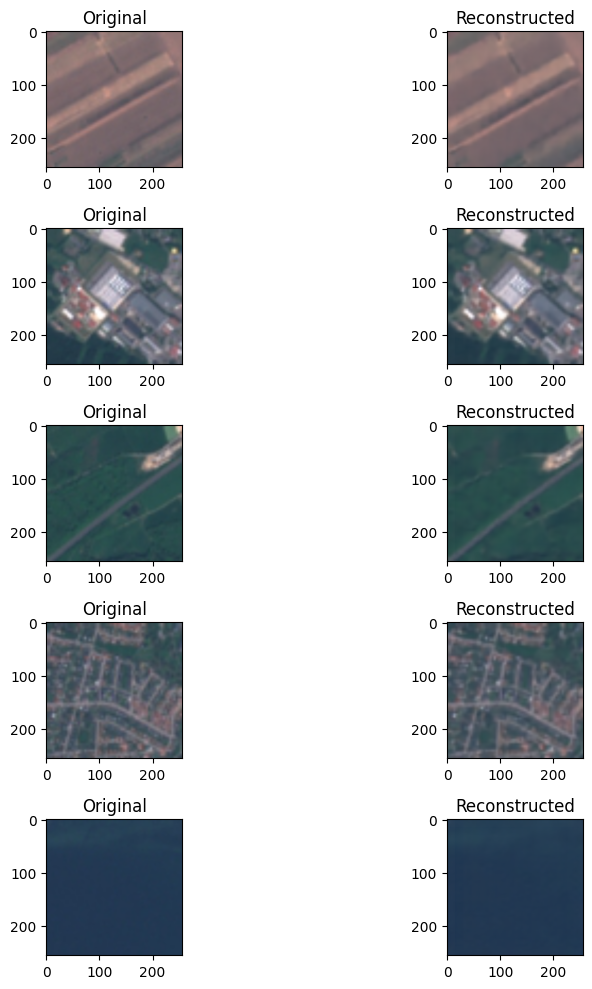

Average PSNR: 42.696261118149614, Average SSIM: 0.9978322266826968
Alpha: 1, Beta: 0.075, Gamma: 10, Loss: 0.3717, Accuracy: 0.9269, F1 Score: 0.9265, BPP: 0.2351
8


c:\Users\Alessandro\anaconda3\Lib\site-packages\torch\nn\modules\transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch 1, Loss: 1.760511048105028
Epoch 2, Loss: 0.8566778764018306
Epoch 3, Loss: 0.5663008305982307
Epoch 4, Loss: 0.46440831970285484
Epoch 5, Loss: 0.38414872390252575
Epoch 6, Loss: 0.33542616494275906
Epoch 7, Loss: 0.3016956463787291
Epoch 8, Loss: 0.2720188386462353
Epoch 9, Loss: 0.25140900321580745
Epoch 10, Loss: 0.22355544986548248
Epoch 11, Loss: 0.20393784144410382
Epoch 12, Loss: 0.18918152980230474
Epoch 13, Loss: 0.1726303760983326
Epoch 14, Loss: 0.1525796601176262
Epoch 15, Loss: 0.14585174046180865
Epoch 16, Loss: 0.14349844127341552
Epoch 17, Loss: 0.12905997684708348
Epoch 18, Loss: 0.1233616770086465
Epoch 19, Loss: 0.11257403103841676
Epoch 20, Loss: 0.11409912331236734
Epoch 21, Loss: 0.10631933777972503
Epoch 22, Loss: 0.10783783439132902
Epoch 23, Loss: 0.10055422892725026
Epoch 24, Loss: 0.09934131604653818
Epoch 25, Loss: 0.09772042605612014
Epoch 26, Loss: 0.09102889246410793
Epoch 27, Loss: 0.08605107507220021
Epoch 28, Loss: 0.09237510548145683
Epoch 29, 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.18212405..1.019333].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.13549624..1.0060045].


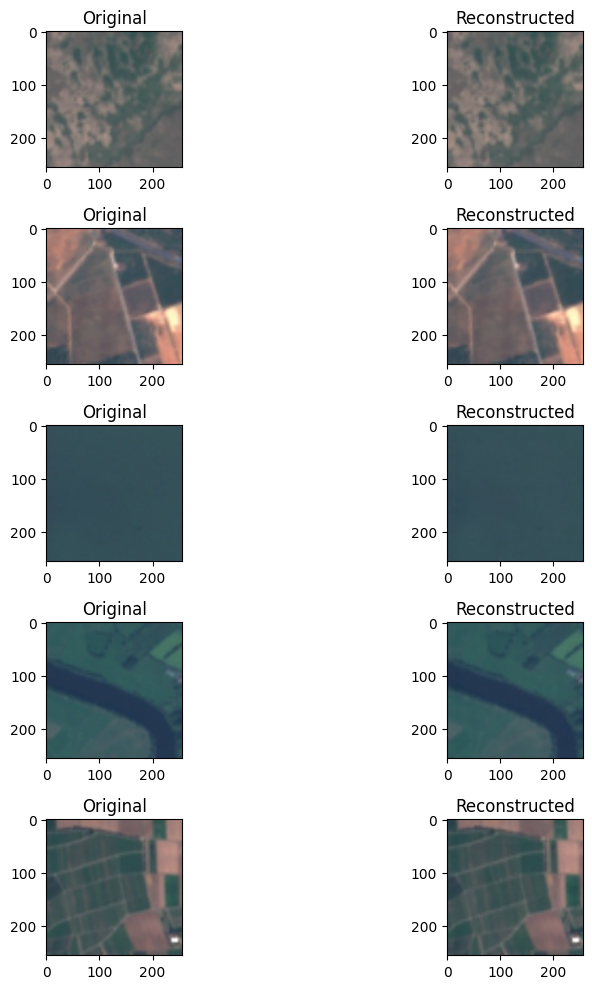

Average PSNR: 46.37162214200172, Average SSIM: 0.9991315479814653
Alpha: 1, Beta: 0.075, Gamma: 10, Loss: 0.3277, Accuracy: 0.9304, F1 Score: 0.9302, BPP: 0.4179


In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import math
import itertools
import datetime
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from torch.utils.tensorboard import SummaryWriter

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define ranges for grid search
alpha_values = [1]
beta_values = [0.075]
gamma_values = [10]

for c_model in model_list3:

    if c_model in [bmshj2018_hyperprior, bmshj2018_factorized, mbt2018, mbt2018_mean]:
        start, step, end = 5, 3, 9  # Starting at 2, stepping by 3, up to but not including 9
        Bigger_size = True
    else:
        Bigger_size = False
        start, step, end = 4, 2, 5  # Starting at 2, stepping by 2, up to but not including 7

    print(c_model)

    for i in range(start, end, step):
        print(i)
        model = c_model(quality=i, metric='mse', pretrained=True, progress=True).to(device)
        
        if Bigger_size is True and i > 4:
            net = TransformerClassifier(in_size=320*16*16, num_classes=10).to(device)
        elif Bigger_size is False and i < 4:
            net = TransformerClassifier(in_size=128*16*16, num_classes=10).to(device)
        else:
            net = TransformerClassifier(in_size=192*16*16, num_classes=10).to(device)

        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(list(net.parameters()) + list(model.parameters()), lr=0.00001)

        # Perform grid search over alpha, beta, and gamma
        for alpha, beta, gamma in itertools.product(alpha_values, beta_values, gamma_values):
            writer = SummaryWriter(f'C:/Users/Alessandro/Desktop/Personal/Contribution 1/Scripts/Pretrained/Tensorboard/{datetime.datetime.now().strftime("%Y%m%d-%H%M%S")}'
                                   f'_{c_model.__name__}_{i}_Transformer_FT_Beta_{beta}_Gamma_{gamma}_Alpha_{alpha}')
            
            train(model.to(device), net.to(device), criterion, optimizer, train_dataloader, writer, alpha=alpha, beta=beta, gamma=gamma, epochs=50)
            
            avg_loss, accuracy, f1, bpp_loss = test(model, net, criterion, test_dataloader)
            avg_psnr, avg_ssim, reconstruction_fig = test_model(test_dataloader, model.to(device), device)

            writer.add_scalar(f'{c_model.__name__}_loss', avg_loss, i)
            writer.add_scalar(f'{c_model.__name__}_accuracy', accuracy, i)
            writer.add_scalar(f'{c_model.__name__}_f1', f1, i)
            writer.add_scalar(f'{c_model.__name__}_bpp', bpp_loss, i)
            writer.add_scalar(f'{c_model.__name__}_PSNR', avg_psnr, i)
            writer.add_scalar(f'{c_model.__name__}_SSIM', avg_ssim, i)
            writer.add_scalar(f'{c_model.__name__}_Beta', beta, i)
            writer.add_scalar(f'{c_model.__name__}_Gamma', gamma, i)
            writer.add_scalar(f'{c_model.__name__}_Alpha', alpha, i)

            # Extract latents and labels
            latents, labels = extract_latents(model.to(device), test_dataloader, device=device)

            # Create a t-SNE plot and save to TensorBoard
            fig, ax = plt.subplots(figsize=(10, 6))
            tsne = TSNE(n_components=2, perplexity=30, n_iter=500)
            T = tsne.fit_transform(latents)
            scatter = ax.scatter(T[:, 0], T[:, 1], c=labels, s=10, cmap='viridis', alpha=0.6)
            plt.colorbar(scatter, label='Class Labels')
            plt.title(f't-SNE visualization of {c_model.__name__} Latents with Labels')
            plt.xlabel('t-SNE 1')
            plt.ylabel('t-SNE 2')

            # Log the t-SNE plot to TensorBoard
            writer.add_figure(f'{c_model.__name__}_t-SNE', fig, i)

            # Log the reconstruction images to TensorBoard
            writer.add_figure(f'{c_model.__name__}_Reconstructions', reconstruction_fig, i)

            writer.flush()
            writer.close()
            
            print(f'Alpha: {alpha}, Beta: {beta}, Gamma: {gamma}, Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}, F1 Score: {f1:.4f}, BPP: {bpp_loss:.4f}')


In [ ]:
from torchsummary import summary

# Assuming 'model' is a PyTorch model that has already been defined
print(summary(model, (3,256,256)))  # input_size should be the shape of your model input

In [3]:
import torch

model = mbt2018(quality = 5)

dummy_input = torch.randn(1, 3, 256, 256)  # Change this based on the actual input shape

# Forward pass to get outputs
model.eval()  # Set the model to evaluation mode if not training
with torch.no_grad():  # Ensure no gradients are computed
    output = model(dummy_input)

# Access and print the dimensions of y_likelihood or latent
if 'likelihoods' in output and 'y' in output['likelihoods']:
    y_likelihood = output['likelihoods']['y']
    print('Dimensions of y_likelihood:', y_likelihood.shape)
else:
    print('y_likelihood is not found in the output structure.')




NameError: name 'mbt2018' is not defined

# Notes from underground

### Role of Positional Encoding
Maintaining Spatial Structure:

Just as positional encoding helps maintain the order of tokens in sequences for NLP tasks, it helps maintain the spatial structure of the latent representations in image data.
The positional encodings provide a sense of location for each element in the latent space, which can be crucial for capturing spatial hierarchies and patterns that are important for classification.
Transformer's Attention Mechanism:

The self-attention mechanism in Transformers computes relationships between different positions in the input. Without positional encoding, the Transformer would not differentiate between different positions in the latent space.
By adding positional encodings, the Transformer can attend to different parts of the latent space based on their positions, thus effectively capturing spatial dependencies.
Generalizing Across Latent Spaces:

Positional encodings enable the Transformer to generalize across different latent spaces, making it possible to learn from the positional information within the compressed representations.
This is particularly useful when dealing with varying sizes and shapes of latent spaces derived from different images or even different compression methods.

### Applying Positional Encoding to Latent Spaces
In the implementation of the TransformerClassifier, positional encoding can be applied to the flattened latent representations as follows:

Flattening Latent Spaces:

The latent space representation of an image, which might originally be in a 3D shape (e.g., [batch_size, channels, height, width]), is flattened to a 2D shape (e.g., [batch_size, sequence_length, embedding_dim]).
Adding Positional Encoding:

Positional encodings are added to these flattened representations to encode spatial information.
Transformer Encoder:

The positional encoding augmented latent spaces are then passed through the Transformer encoder, which can now leverage both the feature information and the positional information to perform classification.